In [12]:
import Pkg; 
Pkg.add("Turing")
Pkg.add("MCMCChains")

   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ✓ LogDensityProblemsAD → LogDensityProblemsADForwardDiffBenchmarkToolsExt
  ✓ DynamicPPL → DynamicPPLEnzymeCoreExt
  2 dependencies successfully precompiled in 11 seconds. 529 already precompiled.
   Resolving package versions...
    Updating `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  [c7f686f2] + MCMCChains v6.0.6
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [1]:
using Turing
using XLSX
using DataFrames, TimeSeries
using StatsPlots
include("utils.jl")

print_percentiles (generic function with 1 method)

In [2]:
data = DataFrame(XLSX.readtable("assets_data_03.24.xlsx", "Indexes_PLN";infer_eltypes=true))
data = TimeArray(data[!,[:Date, :ACWI_Net_PLN]],timestamp=:Date)
returns = percentchange(data,:log)
returns_summarystats(returns,12)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
ACWI_Net_PLN,0.131882,1.27136,0.0697841,0.388241,-1.34382,-0.511507,-0.191836,0.0725772,0.529017,0.52914,0.0948534


In [3]:
0.131882/(12^0.5)

0.03807105410063311

In [4]:
struct GibsSamplerGBM
    returns::Vector{Float64}
    returns_mu::Float64
    T::Int
    n_iter::Int
    mu_dist::Vector{Float64}
    sigma_dist::Vector{Float64}

    function GibsSamplerGBM(returns::Vector{Float64}, init_sigma::Float64, n_iter::Int=10000)
        new(returns, mean(returns), length(returns), n_iter, zeros(n_iter + 1), [init_sigma; zeros(n_iter)])
    end
end

function normal(sampler::GibsSamplerGBM, sigma2::Float64)
    dist = Normal(sampler.returns_mu, sqrt(sigma2 / sampler.T))
    return rand(dist)
end

function inv_gamma(sampler::GibsSamplerGBM, mu::Float64)
    B = 0.5 * sum((sampler.returns .- mu).^2)
    a = sampler.T / 2 + 1
    mean = B / (a - 1)
    dist = InverseGamma(a, B)
    return sqrt(rand(dist))
end


function run!(sampler::GibsSamplerGBM)
    for i in 2:sampler.n_iter
        sampler.mu_dist[i] = normal(sampler, sampler.sigma_dist[i-1]^2)
        sampler.sigma_dist[i] = inv_gamma(sampler, sampler.mu_dist[i])
    end
end



run! (generic function with 1 method)

In [5]:
sampler = GibsSamplerGBM(values(returns),0.038,)
run!(sampler)

In [6]:
describe(sampler.mu_dist*12)

Summary Stats:
Length:         10001
Missing Count:  0
Mean:           0.070003
Std. Deviation: 0.025704
Minimum:        -0.024465
1st Quartile:   0.052728
Median:         0.069930
3rd Quartile:   0.087192
Maximum:        0.177230
Type:           Float64


In [27]:
0.087 - 0.07

0.016999999999999987

In [8]:
describe(sampler.sigma_dist*12^0.5)

Summary Stats:
Length:         10001
Missing Count:  0
Mean:           0.131716
Std. Deviation: 0.005404
Minimum:        0.000000
1st Quartile:   0.128118
Median:         0.131527
3rd Quartile:   0.135146
Maximum:        0.156845
Type:           Float64


In [15]:
0.07 / 12

0.005833333333333334

In [30]:
@model function GBM(y)

    mu ~ Normal(0.0058,0.017)
    sigma ~ InverseGamma(0.038)
       
    return y ~ Normal(mu,sigma)

end

GBM (generic function with 2 methods)

In [31]:
model = GBM(values(returns))
chain = sample(model, NUTS(0.65), 3_000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\matsz\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
Sampling   0%|█                                         |  ETA: 0:02:40
Sampling   1%|█                                         |  ETA: 0:01:20
Sampling   2%|█                                         |  ETA: 0:00:53
Sampling   2%|█                                         |  ETA: 0:00:40
Sampling   2%|██                                        |  ETA: 0:00:32
Sampling   3%|██                                        |  ETA: 0:00:27
Sampling   4%|██                                        |  ETA: 0:00:23
Sampling   4%|██                                        |  ETA: 0:00:20
Sampling   4%|██                                        |  ETA: 0:00:18
Sampling   5%|███                                       |  ETA: 0:00:16
Sampling   6%|███                                       |  ETA: 0:00:14
Sampling 

Chains MCMC chain (3000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 1.65 seconds
Compute duration  = 1.65 seconds
parameters        = mu, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

          mu    0.0059    0.0022    0.0000   2311.7148   1765.3108    1.0010   ⋯
       sigma    0.0398    0.0016    0.0000   1613.0570   1394.3720    1.0009   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [35]:
0.0074 *12

0.0888

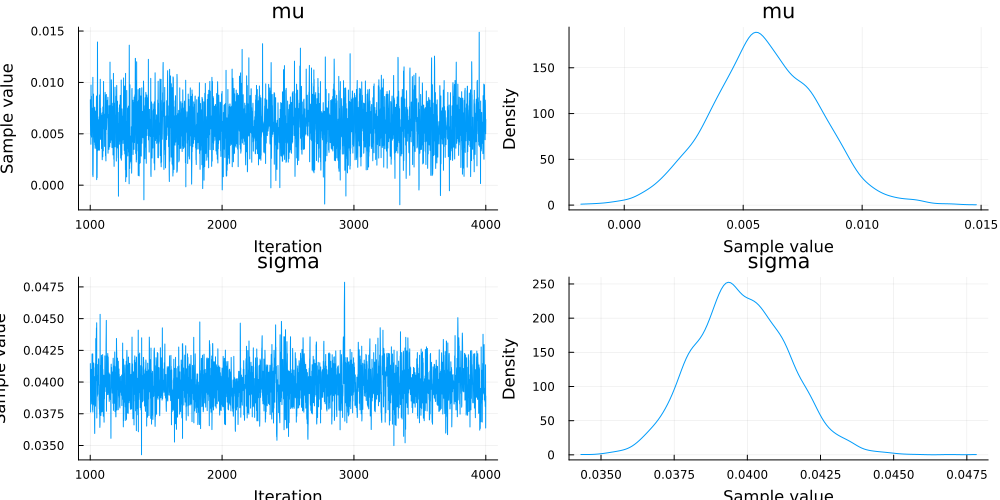

In [32]:
plot(chain)